Oleh Fajar Kurnia

# Persiapan Data

## Transformasi Data

In [1]:
import torch
import re
import pandas as pd
from transformers import pipeline

/home/fakur/miniconda3/envs/bert/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("../data/GOTY_Steam_reviews_english, 100k, latest 28-04-2025.csv")
df2 = pd.read_csv("../data/GOTY_Steam_reviews_english_witcher_baldur.csv")

# Filter out old data from The Witcher 3 and Baldur's Gate
df = df[~df['game'].isin(["Baldur's Gate 3", "The Witcher 3: Wild Hunt"])]

# Merge df with df2 (which contain latest Witcher 3 and Baldur Gate Data)
df = pd.concat([df, df2], ignore_index=True)
df.to_csv("../data/goty_reviews.csv")
df.head()

,timestamp_created,game,review,voted_up,weighted_vote_score,language,author
0,1592261503,Dragon Age: Inquisition,I found a particular mod absolutely essential:...,True,0.960588,english,"{'steamid': '76561197998282606', 'num_games_ow..."
1,1682220637,Dragon Age: Inquisition,"EA Launcher has completely broken this game, S...",False,0.944942,english,"{'steamid': '76561198007277283', 'num_games_ow..."
2,1608014450,Dragon Age: Inquisition,I love this game. I've clocked over 300 hours ...,False,0.919890,english,"{'steamid': '76561197977249754', 'num_games_ow..."
3,1606346717,Dragon Age: Inquisition,Great game with a great story and visuals...\n...,True,0.916374,english,"{'steamid': '76561198202036901', 'num_games_ow..."
4,1653398832,Dragon Age: Inquisition,Origin stops me from opening the game.\nThe on...,False,0.908808,english,"{'steamid': '76561198110956086', 'num_games_ow..."


In [4]:
# Add year column by game release date
## Game titles and corresponding years
game_year_mapping = {
    "The Witcher 3: Wild Hunt": 2015,
    "Baldur's Gate 3": 2023,
    "Sekiro: Shadows Die Twice": 2019,
    "God of War": 2018,
    "Elden Ring": 2022,
    "It Takes Two": 2021,
    "Dragon Age: Inquisition": 2014,
    "The Last of Us Part II": 2020
}

# Adding the 'release_year' column to the existing df based on the 'game' column
df['release_year'] = df['game'].map(game_year_mapping)

# convert to date format
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], unit='s')

# Extract year and month
df['reviews_year'] = df['timestamp_created'].dt.year
df['reviews_month'] = df['timestamp_created'].dt.month
df['reviews_day'] = df['timestamp_created'].dt.day

df.head()

,timestamp_created,game,review,voted_up,weighted_vote_score,language,author,release_year,reviews_year,reviews_month,reviews_day
0,2020-06-15 22:51:43,Dragon Age: Inquisition,I found a particular mod absolutely essential:...,True,0.960588,english,"{'steamid': '76561197998282606', 'num_games_ow...",2014,2020,6,15
1,2023-04-23 03:30:37,Dragon Age: Inquisition,"EA Launcher has completely broken this game, S...",False,0.944942,english,"{'steamid': '76561198007277283', 'num_games_ow...",2014,2023,4,23
2,2020-12-15 06:40:50,Dragon Age: Inquisition,I love this game. I've clocked over 300 hours ...,False,0.919890,english,"{'steamid': '76561197977249754', 'num_games_ow...",2014,2020,12,15
3,2020-11-25 23:25:17,Dragon Age: Inquisition,Great game with a great story and visuals...\n...,True,0.916374,english,"{'steamid': '76561198202036901', 'num_games_ow...",2014,2020,11,25
4,2022-05-24 13:27:12,Dragon Age: Inquisition,Origin stops me from opening the game.\nThe on...,False,0.908808,english,"{'steamid': '76561198110956086', 'num_games_ow...",2014,2022,5,24


## Pembersihan Data

In [5]:
# Check data shape, and info
def dataset_info():
    print(f'--------------------------------------|||||||||||||-------------------------------------- \n')
    print(f'Dataset shape : {df.shape} \n')
    print(f'--------------------------------------|||||||||||||-------------------------------------- \n')
    print(f'{df.info()}\n')
    print(f'--------------------------------------|||||||||||||-------------------------------------- \n')
    print(f"Game List:\n{df['game'].value_counts()}\n")
    print(f'--------------------------------------|||||||||||||-------------------------------------- \n')
dataset_info()

--------------------------------------|||||||||||||-------------------------------------- 

Dataset shape : (656189, 11) 

--------------------------------------|||||||||||||-------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656189 entries, 0 to 656188
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   timestamp_created    656189 non-null  datetime64[ns]
 1   game                 656189 non-null  object        
 2   review               654666 non-null  object        
 3   voted_up             656189 non-null  bool          
 4   weighted_vote_score  656189 non-null  float64       
 5   language             656189 non-null  object        
 6   author               656189 non-null  object        
 7   release_year         656189 non-null  int64         
 8   reviews_year         656189 non-null  int32         
 9   reviews_month        656189 non

In [6]:
# Check for missing value / null
print(f"Missing Value Check \n{df.isnull().sum()} \n")
print(f"What game that have missing value :\n{df[df.isnull().any(axis=1)]['game'].value_counts()} \n ")
print(f"data shape : {df.shape}\n")

# Drop the missing value
df = df.dropna()

# Check for missing value / null
print(f"Missing Value Check \n{df.isnull().sum()} \n")
print(f"What game that have missing value :\n{df[df.isnull().any(axis=1)]['game'].value_counts()} \n ")
print(f"data shape : {df.shape}\n")

Missing Value Check 
timestamp_created         0
game                      0
review                 1523
voted_up                  0
weighted_vote_score       0
language                  0
author                    0
release_year              0
reviews_year              0
reviews_month             0
reviews_day               0
dtype: int64 

What game that have missing value :
game
The Witcher 3: Wild Hunt     696
God of War                   329
Sekiro: Shadows Die Twice    246
It Takes Two                 160
Dragon Age: Inquisition       55
The Last of Us Part II        33
Baldur's Gate 3                3
Elden Ring                     1
Name: count, dtype: int64 
 
data shape : (656189, 11)

Missing Value Check 
timestamp_created      0
game                   0
review                 0
voted_up               0
weighted_vote_score    0
language               0
author                 0
release_year           0
reviews_year           0
reviews_month          0
reviews_day            0

## Pra-pemrosesan Data

In [7]:
import nltk

# Download NLTK stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/fakur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Clean text function
def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove mentions (@usernames)
    text = re.sub(r'@\w+', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stopwords
    # stop_words = set(stopwords.words('english'))  # You can change the language here if needed
    # text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

In [9]:
# Load BERT Models & Check system (is it support for cuda)
# Load sentiment analysis pipeline using the `nlptown/bert-base-multilingual-uncased-sentiment` model
sentiment_pipeline = pipeline("text-classification", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Check the device being used (GPU or CPU)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("CUDA device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

Device set to use cuda:0


CUDA available: True
CUDA device count: 1
CUDA device name: NVIDIA GeForce GTX 1060 6GB


In [10]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd

# Load the model and tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = BertTokenizer.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check if CUDA is available
model = BertForSequenceClassification.from_pretrained(model_name).to(device)  # Move the model to the correct device

print(f"Device used : {device}")

Device used : cuda


# Analisis

In [11]:
# Function to tokenize with BERT, selecting overlapping segments
def tokenize_with_bert(text, max_tokens=512):
    tokenized_text = tokenizer.tokenize(text)
    
    # If text is within the limit, return as is
    if len(tokenized_text) <= max_tokens:
        return text

    # Segment the review with more overlapping tokens
    segment_size = max_tokens // 4  # Using 4 segments instead of 3
    selected_tokens = (
        tokenized_text[:segment_size] + 
        tokenized_text[len(tokenized_text)//4: len(tokenized_text)//4 + segment_size] +
        tokenized_text[len(tokenized_text)//2: len(tokenized_text)//2 + segment_size] + 
        tokenized_text[-segment_size:]
    )
    
    # Convert back to text
    selected_text = tokenizer.convert_tokens_to_string(selected_tokens)
    return selected_text

# Function to analyze sentiment and binarize into Positive and Negative
def analyze_sentiment_and_keep_context(text, chunk_size=512):
    # Clean the review text
    cleaned_text = clean_text(text)

    # Tokenize and process the review
    processed_review = tokenize_with_bert(cleaned_text, max_tokens=chunk_size)
    
    # Tokenize the processed review for sentiment analysis
    inputs = tokenizer(processed_review, return_tensors="pt", padding=True, truncation=True, max_length=chunk_size).to(device)

    # Forward pass through the model
    with torch.no_grad():
        logits = model(**inputs).logits

    # Get the predicted sentiment label (0: Very Negative, 1: Negative, 2: Neutral, 3: Positive, 4: Very Positive)
    sentiment_label = torch.argmax(logits, dim=1).item()
    
    # Binarize sentiment: Map to "Negative" if sentiment is 0, 1, or 2; "Positive" if sentiment is 3 or 4
    if sentiment_label in [0, 1]:
        sentiment_label = "Negative"
    else:
        sentiment_label = "Positive"
    
    return sentiment_label, processed_review

## Inferensi BERT

In [ ]:
# %%time

# from tqdm import tqdm
# tqdm.pandas()  # Enables tqdm for pandas apply

# # Apply the function to each review in the dataframe
# df[['sentiment', 'processed_review']] = df['review'].progress_apply(lambda x: pd.Series(analyze_sentiment_and_keep_context(x)))

# # Display the updated dataframe with sentiment labels and processed reviews
# df.to_csv('../output/bert-result.csv')
# df.head()

  0%|          | 0/654666 [00:00<?, ?it/s]

100%|██████████| 654666/654666 [3:11:29<00:00, 63.80it/s]   

## Evaluasi

In [2]:
df = pd.read_csv('../output/bert_result.csv')

In [13]:
# Convert timestamp to datetime
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'])

#Filter the DataFrame to exclude 'Baldur's Gate 3' in 'game' column and dates < '2023-08-03'
df = df[~((df['game'] == "Baldur's Gate 3") & (df['timestamp_created'] < '2023-08-03'))]

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Ground truth: True -> 1 (positive), False -> 0 (negative)
y_true = df['voted_up'].astype(int)

# BERT prediction: 'Positive' -> 1, 'Negative' -> 0
y_pred = df['sentiment'].map({'Positive': 1, 'Negative': 0})

In [15]:
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1-score:", f1_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

Accuracy: 0.892285462997864
Precision: 0.9879052875972284
Recall: 0.8983177828052068
F1-score: 0.9409840241075408
Confusion Matrix:
 [[ 21365   6694]
 [ 61890 546771]]


In [16]:
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.26      0.76      0.38     28059
    Positive       0.99      0.90      0.94    608661

    accuracy                           0.89    636720
   macro avg       0.62      0.83      0.66    636720
weighted avg       0.96      0.89      0.92    636720



In [17]:
df['game'].value_counts()

game
The Witcher 3: Wild Hunt     237846
Baldur's Gate 3              114851
Sekiro: Shadows Die Twice     90295
God of War                    70874
Elden Ring                    56698
It Takes Two                  48729
Dragon Age: Inquisition       10858
The Last of Us Part II         6569
Name: count, dtype: int64

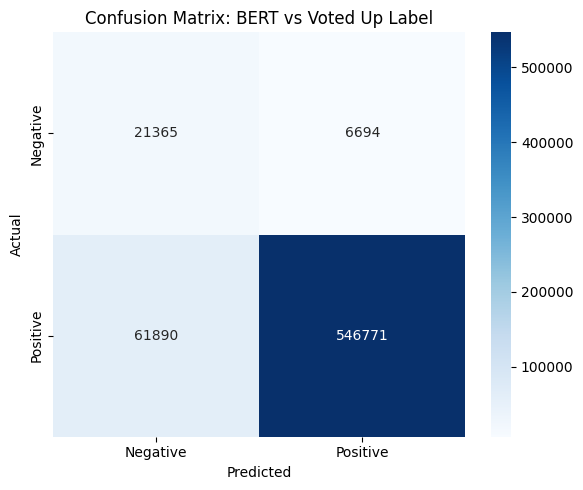

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = ['Negative', 'Positive']

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: BERT vs Voted Up Label')
plt.tight_layout()
plt.show()

## Penandaan Manual

In [20]:
# Stopword Cleaning
import nltk
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def cleaned_reviews(text, extra_stopwords=None):
    if extra_stopwords is None:
        extra_stopwords = set()

    # Combine NLTK stopwords with your custom ones
    stop_words = set(stopwords.words('english')).union(extra_stopwords)

    # Lowercase
    text = str(text).lower()

    # Remove URLs, punctuation, numbers, and extra spaces
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stopwords and lemmatize
    
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)
    
    return text

[nltk_data] Downloading package stopwords to /home/fakur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/fakur/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
%%time
# Define custom/game-related stopwords
custom_stopwords = {'sekiro', 'elden', 'ring', 'witcher', 'game', 'games','play','played','one','get','pc','much'}

# Clean the reviews
df['cleaned_review'] = df['review'].apply(lambda x: cleaned_reviews(x, extra_stopwords=custom_stopwords))

CPU times: user 2min 10s, sys: 8.83 s, total: 2min 19s
Wall time: 2min 19s


In [21]:
from collections import Counter

# Get word co-occurrence around known aspect words
def get_cooccurring_words(df, keywords, window=5):
    cooccur = Counter()
    for text in df['cleaned_review']:
        tokens = text.split()
        for i, word in enumerate(tokens):
            if word in keywords:
                start = max(0, i - window)
                end = min(len(tokens), i + window + 1)
                context = tokens[start:end]
                cooccur.update([w for w in context if w != word])
    return cooccur.most_common(20)

# Example looking for Gameplay Aspect
get_cooccurring_words(df, ['gameplay'])

[('story', 14775),
 ('good', 11913),
 ('great', 7794),
 ('graphic', 5419),
 ('amazing', 4971),
 ('fun', 4491),
 ('character', 4083),
 ('hour', 3983),
 ('long', 3561),
 ('world', 3365),
 ('like', 3246),
 ('mehh', 3110),
 ('best', 3097),
 ('combat', 3021),
 ('watch', 2996),
 ('mechanic', 2891),
 ('dont', 2871),
 ('really', 2774),
 ('msdos', 2771),
 ('time', 2441)]

In [22]:
aspect_keywords = {
    'Graphics': ['graphics', 'visuals', 'animation', 'design', 'art', 'look', 'environment', 'lighting','beautiful','stunning','masterpiece','look','wonderful','graphic','design'],
    'Story': ['story', 'plot', 'narrative', 'dialogue', 'writing', 'lore', 'ending', 'cutscene', 'cinematic','great','gameplay','amazing','character','best','lore','quest','telling'],
    'Combat': ['combat','block','smashed', 'fight', 'battles', 'parry', 'boss', 'enemy', 'weapon', 'slash', 'attack', 'swordplay','system','soul','satisfying','tactical'],
    'Difficulty': ['difficulty', 'hard', 'challenging', 'easy', 'frustrating', 'die', 'punishing', 'trial', 'rage', 'gitgud','level','soulsborne','soul','boss','tough','top'],
    'Music/Sound': ['music', 'sound', 'audio', 'voice', 'soundtrack', 'bgm', 'effects', 'ambience','voice','heard','effect','boy'],
    'Performance': ['fps', 'lag', 'crash', 'bug', 'performance', 'optimization', 'stutter', 'frame drop','issue','run','experience','enjoyable','stuttering','poor'],
    'Gameplay': ['gameplay', 'mechanic', 'feature', 'control', 'movement', 'explore', 'freedom', 'replayability','good','mechanic','love','rpg','fun']
}

In [23]:
%%time
#Extract the aspect from dataset

def extract_aspects(text, aspect_dict):
    found_aspects = []
    text = text.lower()
    for aspect, keywords in aspect_dict.items():
        if any(kw in text for kw in keywords):
            found_aspects.append(aspect)
    return found_aspects if found_aspects else ['Other']

df['aspects'] = df['cleaned_review'].apply(lambda x: extract_aspects(x, aspect_keywords))

CPU times: user 10.5 s, sys: 104 ms, total: 10.6 s
Wall time: 9.73 s


In [24]:
# Explode aspects column into multiple rows per game
aspect_counts = df.explode('aspects').groupby(['game', 'aspects']).size().reset_index(name='count')

aspect_counts

,game,aspects,count
0,Baldur's Gate 3,Combat,23447
1,Baldur's Gate 3,Difficulty,27041
2,Baldur's Gate 3,Gameplay,71419
3,Baldur's Gate 3,Graphics,41990
4,Baldur's Gate 3,Music/Sound,15111
...,...,...,...
59,The Witcher 3: Wild Hunt,Graphics,48213
60,The Witcher 3: Wild Hunt,Music/Sound,12824
61,The Witcher 3: Wild Hunt,Other,76831
62,The Witcher 3: Wild Hunt,Performance,21669


In [31]:
df_patch = pd.read_csv("../output/steam_update_info.csv")
df_patch

,game_id,game_title,original_date,cleaned_date,title,topic,desc
0,1222690,Dragon Age: Inquisition,"21 Jun, 2024",2024-06-21,NaN,Other,"Attention, gamers! Don't miss out on this incr..."
1,1222690,Dragon Age: Inquisition,"10 Jun, 2024",2024-06-10,NaN,Other,Watch this new trailer to meet your team of se...
2,1222690,Dragon Age: Inquisition,"25 Aug, 2020",2020-08-25,NaN,Other,Dragon Age Inquisition Achievements have just ...
3,292030,The Witcher 3: Wild Hunt,4 Jun,2025-06-04,NaN,Other,"Direct from the State of Unreal 2025, we are e..."
4,292030,The Witcher 3: Wild Hunt,2 Jun,2025-06-02,NaN,Other,"Berries tart, lilac sweet...This May, we’re ce..."
...,...,...,...,...,...,...,...
238,1086940,Baldur's Gate 3,"Aug 10, 2023",2023-08-10,NaN,Fix,"Hello everyone,As it turns out, many of you we..."
239,1086940,Baldur's Gate 3,"Aug 8, 2023",2023-08-08,NaN,Fix,"Hello everyone,Over the weekend, Baldur’s Gate..."
240,1086940,Baldur's Gate 3,"Aug 5, 2023",2023-08-05,NaN,Update,"Hello everyone,Happy post-BG3-launch day! Than..."
241,1086940,Baldur's Gate 3,"Aug 3, 2023",2023-08-03,NaN,Update,Six years in the making and more than twenty y...


In [41]:
sampled_df = df.groupby('game', group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), 100), random_state=42)
    )
sampled_df.to_csv("../output/bert-result-sample.csv")
sampled_df

/tmp/ipykernel_2839/1540790499.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('game', group_keys=False).apply(


,Unnamed: 0,timestamp_created,game,review,voted_up,weighted_vote_score,language,author,release_year,reviews_year,reviews_month,reviews_day,sentiment,processed_review,cleaned_review,aspects,review_month_dt,review_month_str
539820,541340,2023-11-23 18:30:18,Baldur's Gate 3,Just buy it already. Waiting to finish it on m...,True,0.521739,english,"{'steamid': '76561198140452367', 'num_games_ow...",2023,2023,11,23,Positive,just buy it already waiting to finish it on my...,buy already waiting finish super ultrawide fir...,[Other],2023-11-01,Nov 2023
613294,614814,2023-08-11 14:28:37,Baldur's Gate 3,One of the greatest games of all time in my op...,True,0.498084,english,"{'steamid': '76561199095128302', 'num_games_ow...",2023,2023,8,11,Positive,one of the greatest games of all time in my op...,greatest time opinion even fan genre itll pull...,"[Story, Gameplay]",2023-08-01,Aug 2023
625111,626634,2023-08-04 19:24:40,Baldur's Gate 3,DO NOT BUY...THIS GAME IS TOTAL GARBAGE!!! It...,False,0.470764,english,"{'steamid': '76561198006622089', 'num_games_ow...",2023,2023,8,4,Negative,do not buythis game is total garbage it has no...,buythis total garbage direction instruction in...,"[Performance, Gameplay]",2023-08-01,Aug 2023
586857,588377,2023-08-28 08:42:47,Baldur's Gate 3,Some cut scene glitches but nothing un-enjoyab...,True,0.500000,english,"{'steamid': '76561199434757761', 'num_games_ow...",2023,2023,8,28,Positive,some cut scene glitches but nothing unenjoyabl...,cut scene glitch nothing unenjoyable good turn...,"[Graphics, Story, Performance, Gameplay]",2023-08-01,Aug 2023
524504,526024,2024-04-08 19:13:58,Baldur's Gate 3,Fantastic RPG. Really good story and lovely ch...,True,0.545455,english,"{'steamid': '76561198966613605', 'num_games_ow...",2023,2024,4,8,Positive,fantastic rpg really good story and lovely cha...,fantastic rpg really good story lovely charact...,"[Story, Gameplay]",2024-04-01,Apr 2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415676,417100,2025-03-31 09:53:35,The Witcher 3: Wild Hunt,This Game is awesome,True,0.500000,english,"{'steamid': '76561199558800297', 'num_games_ow...",2015,2025,3,31,Positive,this game is awesome,awesome,[Other],2025-03-01,Mar 2025
357462,358286,2017-09-18 03:40:03,The Witcher 3: Wild Hunt,HOLY SHIT this game has been absolutely amazi...,True,0.500000,english,"{'steamid': '76561197964187351', 'num_games_ow...",2015,2017,9,18,Positive,holy shit this game has been absolutely amazin...,holy shit absolutely amazing never rpg given b...,"[Story, Gameplay]",2017-09-01,Sep 2017
309360,310184,2015-10-16 01:07:23,The Witcher 3: Wild Hunt,The Witcher III: Wild Hunt is a massive scale ...,True,0.515152,english,"{'steamid': '76561198048404577', 'num_games_ow...",2015,2015,10,16,Positive,the witcher iii wild hunt is a massive scale g...,iii wild hunt massive scale ambition gameplay ...,"[Graphics, Story, Combat, Gameplay]",2015-10-01,Oct 2015
352325,353149,2020-08-15 03:14:58,The Witcher 3: Wild Hunt,"The gameplay is pretty boring, even on harder ...",False,0.441673,english,"{'steamid': '76561198026483480', 'num_games_ow...",2015,2020,8,15,Negative,the gameplay is pretty boring even on harder d...,gameplay pretty boring even harder difficulty ...,"[Story, Difficulty, Gameplay]",2020-08-01,Aug 2020


In [18]:
import pandas as pd
import os

def merge_review_and_announcement_data(reviews_csv_path, announcements_csv_path, output_csv_path):
    """
    Loads, cleans, and merges Steam review data with announcement data.

    Args:
        reviews_csv_path (str): Path to the main dataset of Steam reviews.
        announcements_csv_path (str): Path to the processed announcements CSV.
        output_csv_path (str): Path to save the final merged CSV file.
    """
    # --- Step 1: Load and Prepare Data ---
    if not os.path.exists(reviews_csv_path) or not os.path.exists(announcements_csv_path):
        print("Error: Ensure both review and announcement CSV files exist.")
        return

    print("Loading datasets...")
    df_reviews = pd.read_csv(reviews_csv_path)
    df_announcements = pd.read_csv(announcements_csv_path)

    # --- Standardize game column name ---
    if 'game' in df_reviews.columns and 'game_title' not in df_reviews.columns:
        df_reviews.rename(columns={'game': 'game_title'}, inplace=True)
        print("Standardized review data's 'game' column to 'game_title'.")

    print("Preparing date columns for merging...")
    # Convert date columns to datetime objects. 'coerce' will turn unparseable dates into NaT (Not a Time).
    df_reviews['timestamp_created'] = pd.to_datetime(df_reviews['timestamp_created'], errors='coerce')
    df_announcements['cleaned_date'] = pd.to_datetime(df_announcements['cleaned_date'], errors='coerce')

    # --- Data Cleaning ---
    df_reviews.dropna(subset=['timestamp_created', 'game_title'], inplace=True)
    df_announcements.dropna(subset=['cleaned_date', 'game_title'], inplace=True)
    
    # Sort both dataframes. This is still best practice.
    df_reviews = df_reviews.sort_values(by=['game_title', 'timestamp_created'])
    df_announcements = df_announcements.sort_values(by=['game_title', 'cleaned_date'])

    # --- Step 2: Merge Datasets Game by Game (More Robust Method) ---
    print("Merging reviews with announcements game by game...")
    
    merged_dfs = []
    unique_games = df_reviews['game_title'].unique()

    for game in unique_games:
        # Filter data for the current game
        left_df = df_reviews[df_reviews['game_title'] == game]
        right_df = df_announcements[df_announcements['game_title'] == game]

        if right_df.empty:
            # If no announcements for this game, just append the review data
            merged_dfs.append(left_df)
            continue
        
        # Perform the merge on the single-game dataframes
        game_merged_df = pd.merge_asof(
            left=left_df,
            right=right_df,
            left_on='timestamp_created',
            right_on='cleaned_date',
            direction='backward'
        )
        merged_dfs.append(game_merged_df)

    # Combine all the merged dataframes back into one
    df_merged = pd.concat(merged_dfs, ignore_index=True)

    # --- Step 3: Clean Up the Merged DataFrame ---
    df_merged.rename(columns={
        'cleaned_date': 'update_date',
        'topic': 'update_topic',
        'desc': 'update_desc'
    }, inplace=True)
    
    cols_to_drop = ['game_id', 'original_date', 'title']
    df_merged.drop(columns=[col for col in cols_to_drop if col in df_merged.columns], inplace=True, errors='ignore')

    print("Merge complete. New columns 'update_date', 'update_topic', etc. added.")
    
    # --- Step 4: Save the Merged Data ---
    try:
        df_merged.to_csv(output_csv_path, index=False, encoding='utf-8')
        print(f"\nSuccessfully saved merged data to '{output_csv_path}'")
    except Exception as e:
        print(f"An error occurred while saving the merged file: {e}")


if __name__ == '__main__':
    reviews_file = '../output/bert_result.csv'
    announcements_file = '../output/steam_update_info.csv'
    output_file = '../output/steam_reviews_with_updates.csv' # The final output file
    
    merge_review_and_announcement_data(reviews_file, announcements_file, output_file)


Loading datasets...
Standardized review data's 'game' column to 'game_title'.
Preparing date columns for merging...
Merging reviews with announcements game by game...
Merge complete. New columns 'update_date', 'update_topic', etc. added.

Successfully saved merged data to '../output/steam_reviews_with_updates.csv'


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
# Asumsikan df_merged (dari skrip merger) dan df_announcements sudah di-load
# Contoh:
df_merged = pd.read_csv('../output/steam_reviews_with_updates.csv')
df_announcements = pd.read_csv('../output/steam_update_info.csv')
df_merged['timestamp_created'] = pd.to_datetime(df_merged['timestamp_created'])
df_announcements['cleaned_date'] = pd.to_datetime(df_announcements['cleaned_date'])
df_merged.rename(columns={'game_title': 'game'}, inplace=True)
df_announcements.rename(columns={'game_title': 'game'}, inplace=True)


# Pastikan 'review_month' dalam bentuk datetime agar bisa diurutkan
df_merged['review_month_dt'] = df_merged['timestamp_created'].dt.to_period('M').dt.to_timestamp()
df_merged['review_month_str'] = df_merged['review_month_dt'].dt.strftime('%b %Y')  # format tampilan

# Hitung jumlah sentimen bulanan berdasarkan datetime
monthly_sentiment = (
    df_merged.groupby(['game', 'review_month_dt', 'review_month_str', 'sentiment'])
    .size()
    .reset_index(name='count')
)

# Tambahkan kolom nilai signed
monthly_sentiment['signed_count'] = monthly_sentiment.apply(
    lambda row: row['count'] if row['sentiment'] == 'Positive' else -row['count'], axis=1
)

# Siapkan data pengumuman untuk penanda di plot
announcement_markers = df_announcements[['game', 'cleaned_date', 'topic']].copy()
announcement_markers.dropna(subset=['cleaned_date'], inplace=True)
announcement_markers['announcement_month_dt'] = announcement_markers['cleaned_date'].dt.to_period('M').dt.to_timestamp()

# Dapatkan daftar game unik
games = df_merged['game_title_x'].unique()

# Plot satu per satu, urut berdasarkan tanggal
for game in games:
    game_sentiment_data = monthly_sentiment[monthly_sentiment['game'] == game].copy()
    if game_sentiment_data.empty:
        continue

    game_sentiment_data = game_sentiment_data.sort_values('review_month_dt')
    
    # Dapatkan daftar bulan unik untuk game ini untuk posisi sumbu-x
    month_list = game_sentiment_data['review_month_dt'].unique()

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        data=game_sentiment_data,
        x='review_month_str',
        y='signed_count',
        hue='sentiment',
        palette={'Positive': 'green', 'Negative': 'red'},
        dodge=False
    )

    # Tambahkan Garis Vertikal untuk Pengumuman
    game_announcements = announcement_markers[announcement_markers['game'] == game]
    for _, ann in game_announcements.iterrows():
        try:
            # Cari posisi bulan pengumuman di sumbu-x
            position = list(month_list).index(ann['announcement_month_dt'])
            # Gambar garis vertikal pada posisi tersebut
            ax.axvline(x=position, color='blue', linestyle='--', linewidth=1.2, alpha=0.8)
            # Tambahkan teks untuk label update
            ax.text(x=position + 0.1, y=ax.get_ylim()[1] * 0.8, s=ann['topic'], color='blue', rotation=90)
        except ValueError:
            # Ini terjadi jika pengumuman ada di bulan yang tidak memiliki ulasan
            pass

    # Format label sumbu-x agar lebih mudah dibaca
    plt.xticks(rotation=45, ha='right')

    plt.title(f'Tren Sentimen dari Game {game} (dengan Penanda Update)')
    plt.xlabel('Bulan dan Tahun')
    plt.ylabel('Jumlah Ulasan (Positif - Negatif)')
    plt.axhline(0, color='black', linewidth=0.8)
    plt.legend(title='Sentimen')
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_1676/2576828032.py:5: DtypeWarning: Columns (2,14,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_merged = pd.read_csv('../output/steam_reviews_with_updates.csv')


In [ ]:
df_merged['game']

# Visualisasi

In [6]:
df = pd.read_csv('../output/bert_result.csv')
# Convert timestamp to datetime
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'])
df = df[~((df['game'] == "Baldur's Gate 3") & (df['timestamp_created'] < '2023-08-03'))]

## Sentimen Pemain

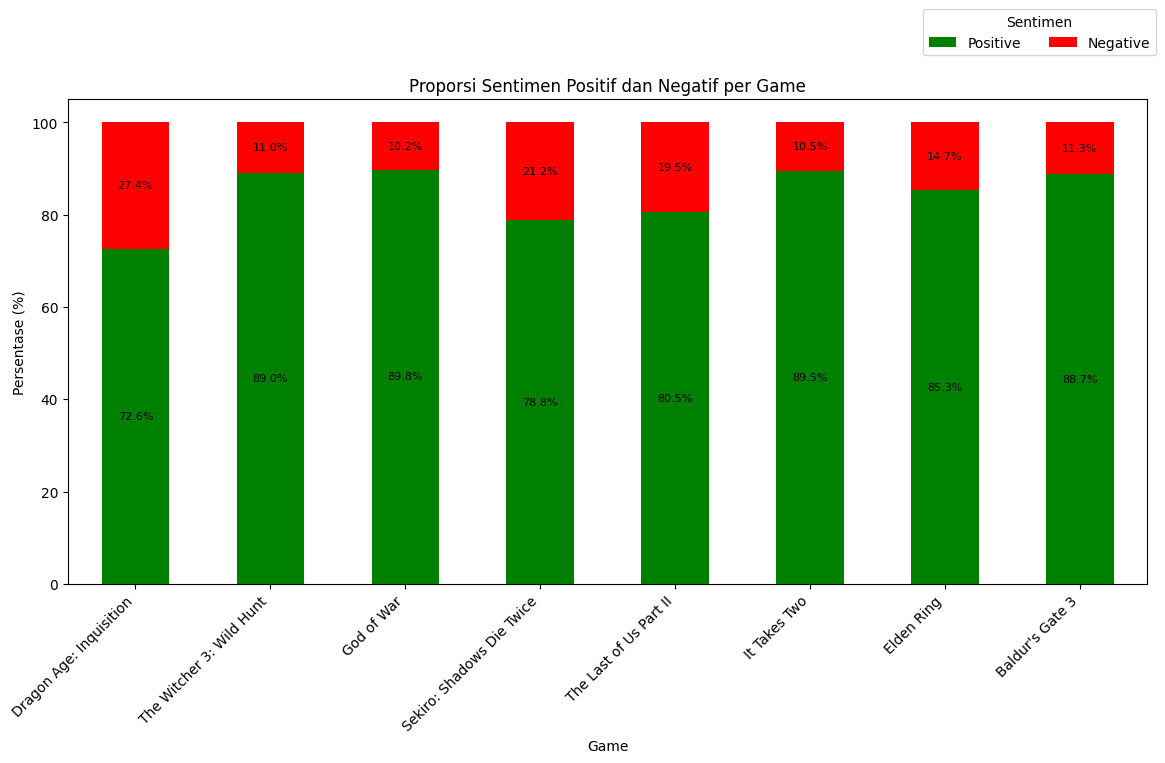

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# calculate each sentimen
sentiment_counts = df.groupby(['game', 'sentiment']).size().reset_index(name='count')

# total count
total_counts = sentiment_counts.groupby('game')['count'].transform('sum')

# calculate each sentiment percentage
sentiment_counts['percentage'] = sentiment_counts['count'] / total_counts * 100

# Pivot data for stacked bar chart
stacked_data = sentiment_counts.pivot(index='game', columns='sentiment', values='percentage').fillna(0)

# sentiment order
if 'Positive' in stacked_data.columns and 'Negative' in stacked_data.columns:
    stacked_data = stacked_data[['Positive', 'Negative']]

# Game order
game_list = [
    "Dragon Age: Inquisition",
    "The Witcher 3: Wild Hunt",
    "God of War",
    "Sekiro: Shadows Die Twice",
    "The Last of Us Part II",
    "It Takes Two",
    "Elden Ring",
    "Baldur's Gate 3"
]


stacked_data_ordered = stacked_data.reindex(game_list)

# Warna khusus untuk sentimen
color_map = {'Positive': 'green', 'Negative': 'red'}

# stacked bar chart
ax = stacked_data_ordered.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    color=[color_map.get(col, 'gray') for col in stacked_data.columns],
    grid=False
)

# Percentage label in the chart
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(
            p.get_x() + p.get_width() / 2.,
            p.get_y() + height / 2,
            f'{height:.1f}%',
            ha='center',
            va='center',
            fontsize=8
        )

plt.title('Proporsi Sentimen Positif dan Negatif per Game')
plt.xlabel('Game')
plt.ylabel('Persentase (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentimen', loc='upper center', bbox_to_anchor=(0.9, 1.2), ncol=2)
plt.tight_layout()
plt.show()

## Tren Sentimen

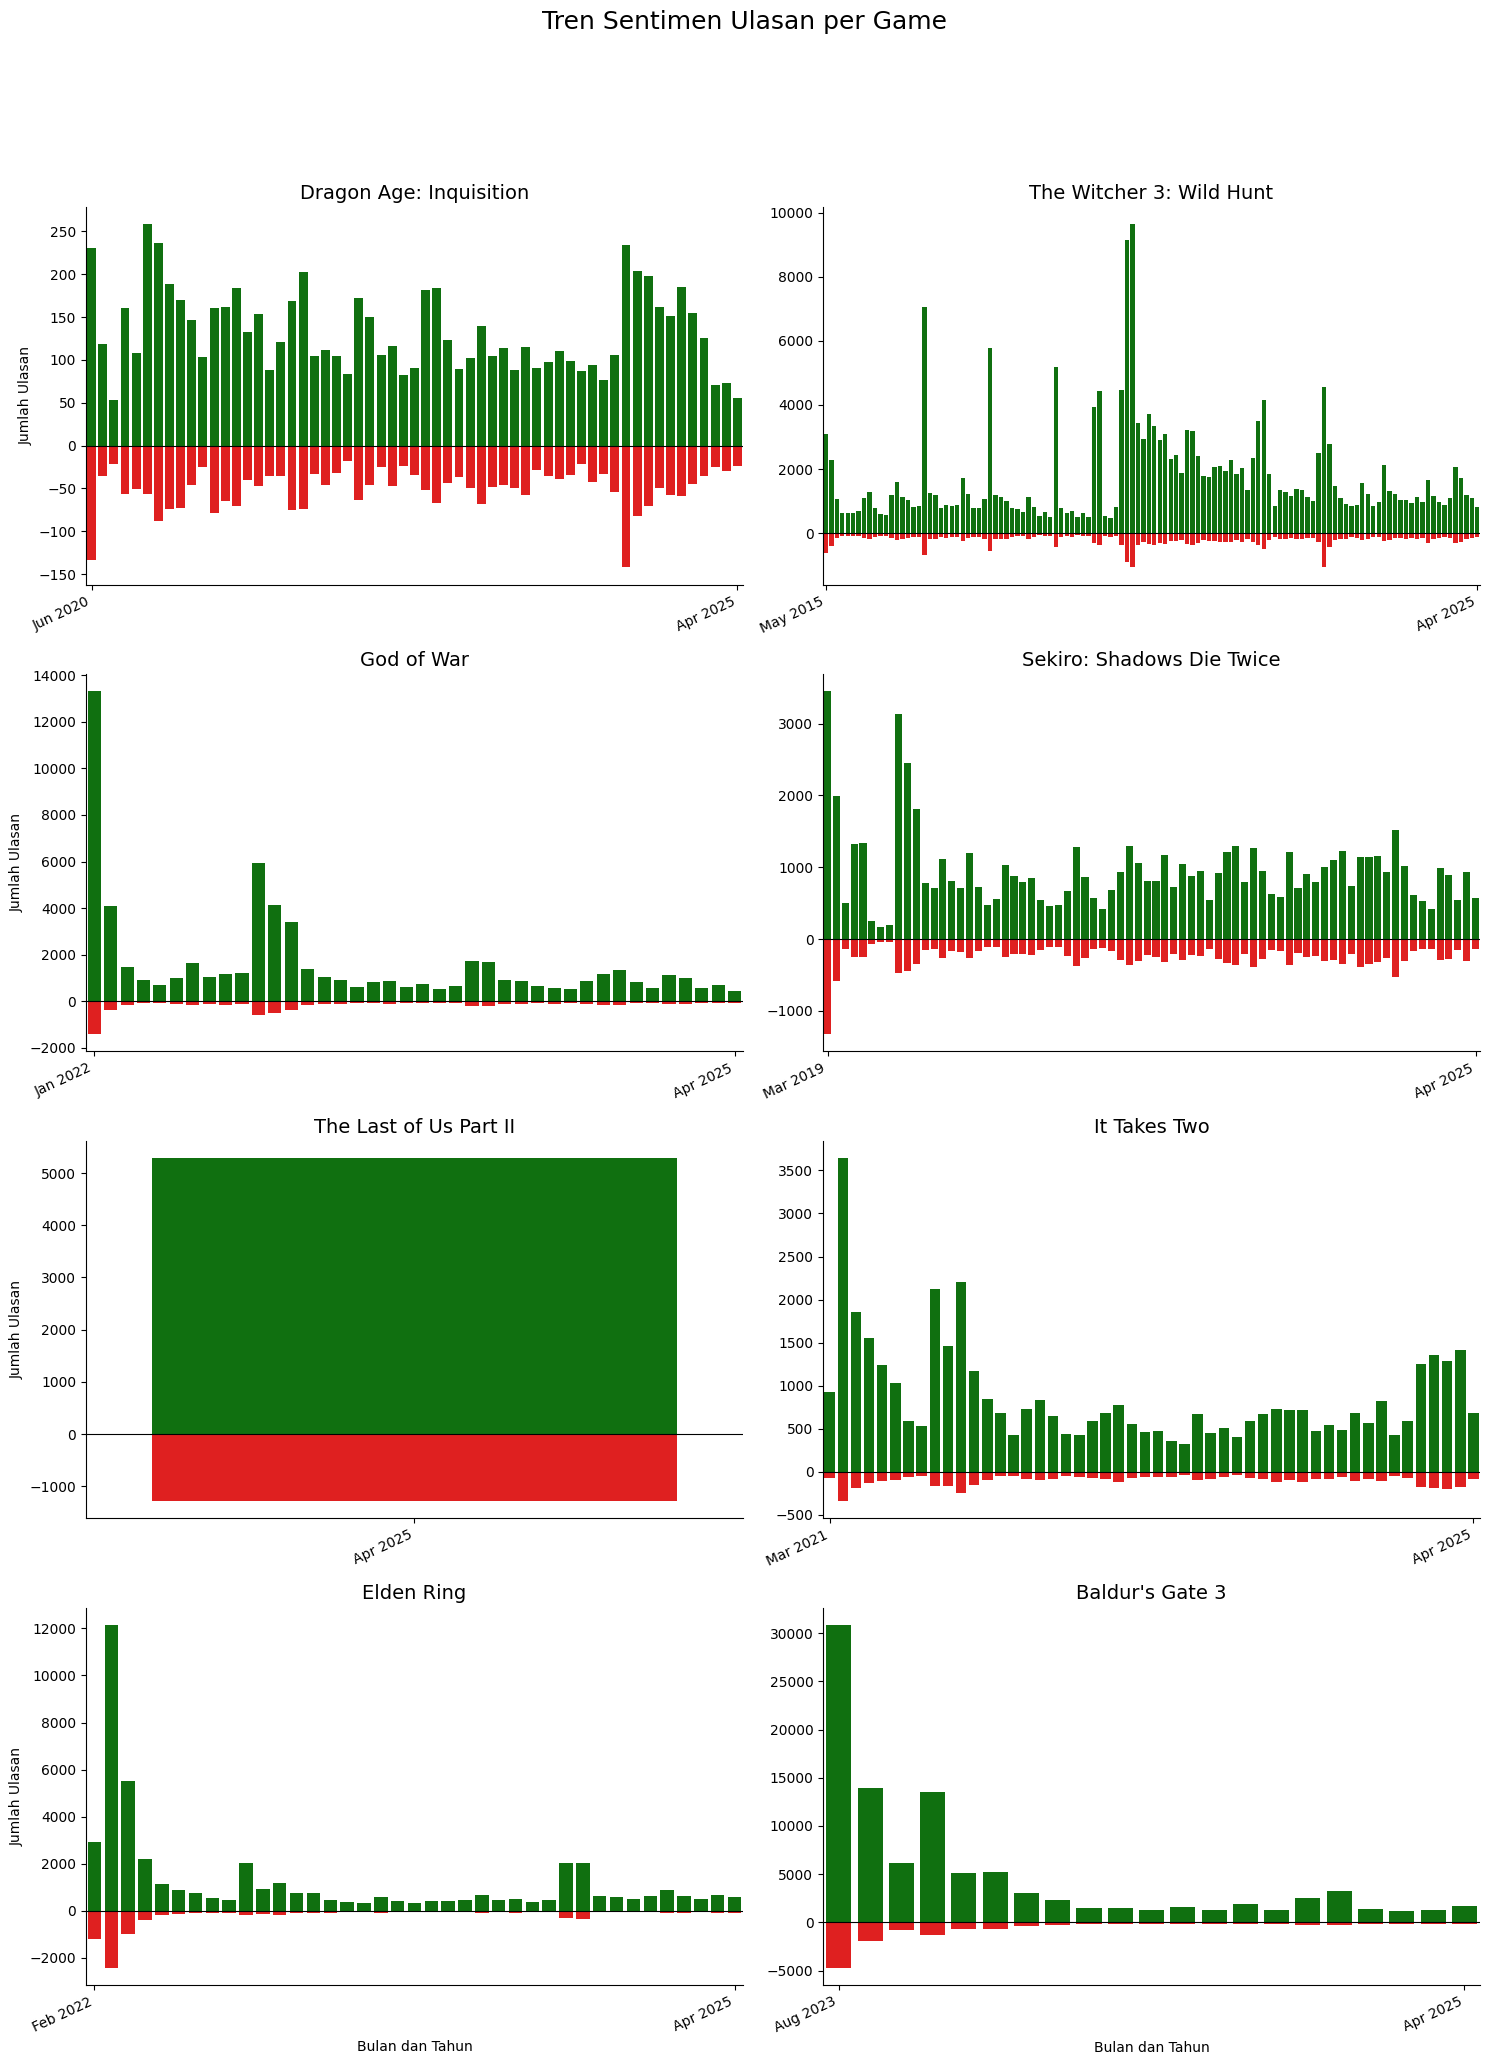

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Asumsikan 'df' adalah DataFrame Anda yang sudah ada
# df['timestamp_created'] = pd.to_datetime(df['timestamp_created'])

# --- (1) PERSIAPAN DATA (Sama seperti sebelumnya) ---
df['review_month_dt'] = df['timestamp_created'].dt.to_period('M').dt.to_timestamp()
df['review_month_str'] = df['review_month_dt'].dt.strftime('%b %Y')

monthly_sentiment = (
    df.groupby(['game', 'review_month_dt', 'review_month_str', 'sentiment'])
    .size()
    .reset_index(name='count')
)

monthly_sentiment['signed_count'] = monthly_sentiment.apply(
    lambda row: row['count'] if row['sentiment'] == 'Positive' else -row['count'], axis=1
)

monthly_sentiment_sorted = monthly_sentiment.sort_values('review_month_dt')

# --- (2) TENTUKAN URUTAN GAME ---
# Daftar ini akan menentukan urutan subplot dari kiri ke kanan, atas ke bawah
game_list = [
    "Dragon Age: Inquisition",
    "The Witcher 3: Wild Hunt",
    "God of War",
    "Sekiro: Shadows Die Twice",
    "The Last of Us Part II",
    "It Takes Two",
    "Elden Ring",
    "Baldur's Gate 3"
]


# --- (3) FUNGSI PLOTTING (Sama seperti sebelumnya) ---
def plot_sentiment_bars(data, **kwargs):
    ax = sns.barplot(
        data=data,
        x='review_month_str',
        y='signed_count',
        hue='sentiment',
        palette={'Positive': 'green', 'Negative': 'red'},
        dodge=False
    )
    
    unique_months = data['review_month_str'].unique()
    if len(unique_months) > 1:
        xticks = [0, len(unique_months) - 1]
        xticklabels = [unique_months[0], unique_months[-1]]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels, rotation=25, ha='right')
    elif len(unique_months) == 1:
        ax.set_xticks([0])
        ax.set_xticklabels([unique_months[0]], rotation=25, ha='right')

    ax.axhline(0, color='black', linewidth=0.8)


# --- (4) MEMBUAT FACETGRID DENGAN URUTAN KUSTOM ---
g = sns.FacetGrid(
    monthly_sentiment_sorted,
    col='game',
    col_order=game_list, # <- TAMBAHKAN PARAMETER INI
    col_wrap=2,
    height=5,
    aspect=1.5,
    sharex=False,
    sharey=False
)

# Terapkan fungsi plotting, atur properti, dan tampilkan
g.map_dataframe(plot_sentiment_bars)
g.set_axis_labels('Bulan dan Tahun', 'Jumlah Ulasan')
g.set_titles(col_template="{col_name}", size=14)
# g.add_legend(title='Sentimen')
g.fig.suptitle('Tren Sentimen Ulasan per Game', y=1.03, fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## Aspek Dominan

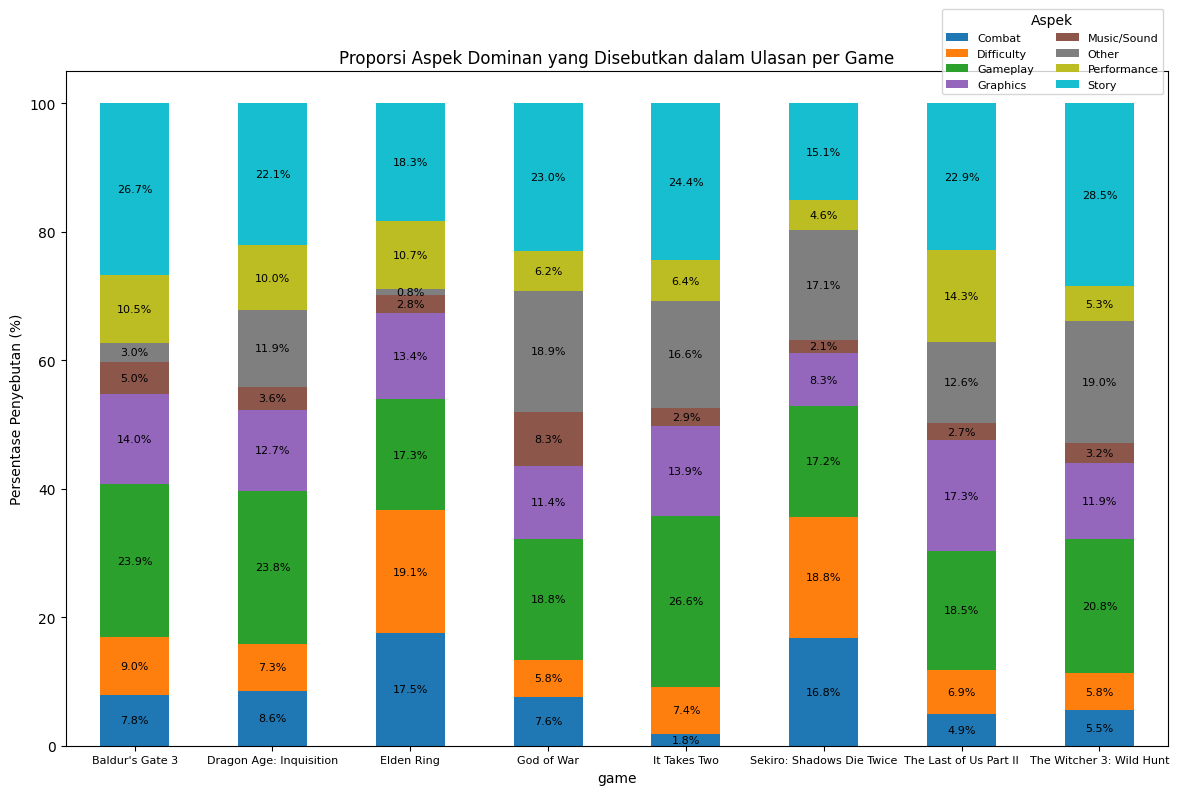

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data
top_aspects = aspect_counts.copy()

# Calculate the proportions for each aspect per game
total_mentions = top_aspects.groupby('game')['count'].transform('sum')
top_aspects['percentage'] = (top_aspects['count'] / total_mentions) * 100

# Pivot data for stacked bar plot
stacked_data = top_aspects.pivot_table(index='game', columns='aspects', values='percentage', aggfunc='sum', fill_value=0)

# Plot stacked bar chart
ax = stacked_data.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab10')

# Add percentage labels on top of each segment
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only add label if the segment has height
        ax.text(p.get_x() + p.get_width() / 2., p.get_y() + height / 2, f'{height:.1f}%', ha='center', va='center', fontsize=8)

# Style
plt.title('Proporsi Aspek Dominan yang Disebutkan dalam Ulasan per Game')
plt.ylabel('Persentase Penyebutan (%)')
plt.xticks(rotation=0, fontsize=8)
plt.legend(title='Aspek', loc='upper right', bbox_to_anchor=(1, 1.1), ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

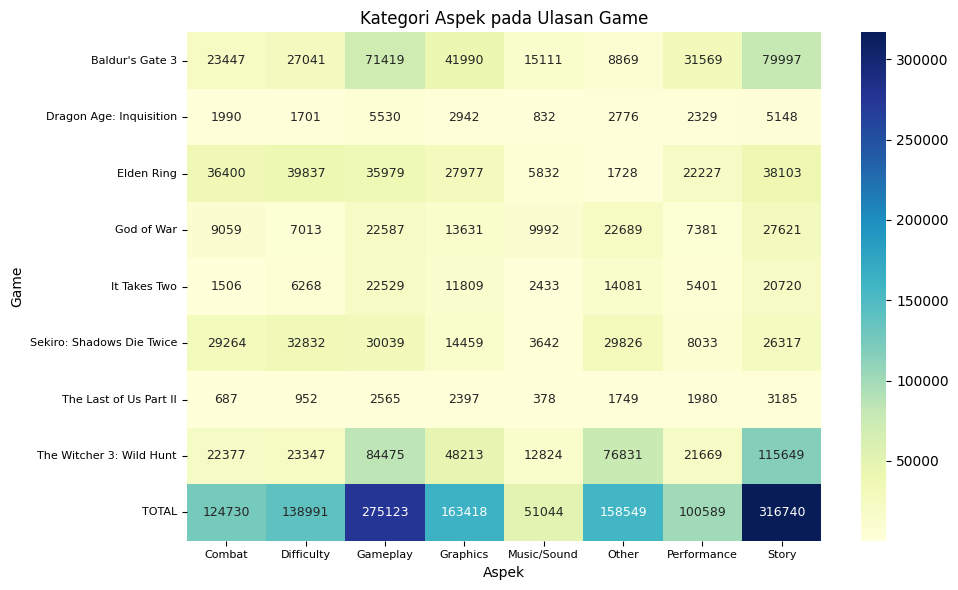

In [36]:
# Buat ulang aspect_matrix
aspect_matrix = aspect_counts.pivot(index='game', columns='aspects', values='count').fillna(0)

# Tambahkan baris TOTAL di bagian bawah
aspect_matrix_with_total = aspect_matrix.copy()
aspect_matrix_with_total.loc['TOTAL'] = aspect_matrix_with_total.sum()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    aspect_matrix_with_total,
    annot=True,
    fmt='.0f',
    cmap='YlGnBu',
    annot_kws={"size": 9}
)

plt.title('Kategori Aspek pada Ulasan Game')
plt.xlabel('Aspek')
plt.ylabel('Game')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

### Aspek Pada Sentimen Positif

In [37]:
# Positive only aspect
aspect_counts_positive = df[df['sentiment'] == 'Positive'].explode('aspects').groupby(['game', 'aspects']).size().reset_index(name='count')
aspect_counts_positive.to_csv('../output/aspect_counts_positive.csv')
aspect_counts_positive

,game,aspects,count
0,Baldur's Gate 3,Combat,20558
1,Baldur's Gate 3,Difficulty,23325
2,Baldur's Gate 3,Gameplay,65351
3,Baldur's Gate 3,Graphics,37304
4,Baldur's Gate 3,Music/Sound,13661
...,...,...,...
59,The Witcher 3: Wild Hunt,Graphics,43687
60,The Witcher 3: Wild Hunt,Music/Sound,11420
61,The Witcher 3: Wild Hunt,Other,62042
62,The Witcher 3: Wild Hunt,Performance,18038


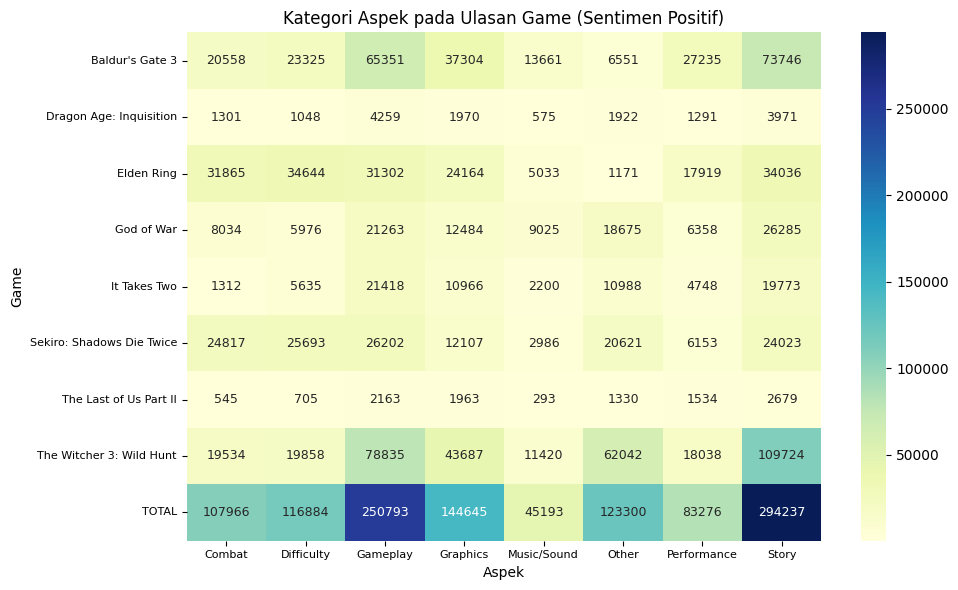

In [38]:
# Buat ulang aspect_matrix
aspect_matrix_pos = aspect_counts_positive.pivot(index='game', columns='aspects', values='count').fillna(0)

# Tambahkan baris TOTAL di bagian bawah
aspect_matrix_with_total_pos = aspect_matrix_pos.copy()
aspect_matrix_with_total_pos.loc['TOTAL'] = aspect_matrix_with_total_pos.sum()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    aspect_matrix_with_total_pos,
    annot=True,
    fmt='.0f',
    cmap='YlGnBu',
    annot_kws={"size": 9}
)

plt.title('Kategori Aspek pada Ulasan Game (Sentimen Positif)')
plt.xlabel('Aspek')
plt.ylabel('Game')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

### Aspek Pada Sentimen Negative

In [39]:
# Negative only aspect
aspect_counts_negative = df[df['sentiment'] == 'Negative'].explode('aspects').groupby(['game', 'aspects']).size().reset_index(name='count')
aspect_counts_negative.to_csv('../output/aspect_counts_negative.csv')
aspect_counts_negative

,game,aspects,count
0,Baldur's Gate 3,Combat,2889
1,Baldur's Gate 3,Difficulty,3716
2,Baldur's Gate 3,Gameplay,6068
3,Baldur's Gate 3,Graphics,4686
4,Baldur's Gate 3,Music/Sound,1450
...,...,...,...
59,The Witcher 3: Wild Hunt,Graphics,4526
60,The Witcher 3: Wild Hunt,Music/Sound,1404
61,The Witcher 3: Wild Hunt,Other,14789
62,The Witcher 3: Wild Hunt,Performance,3631


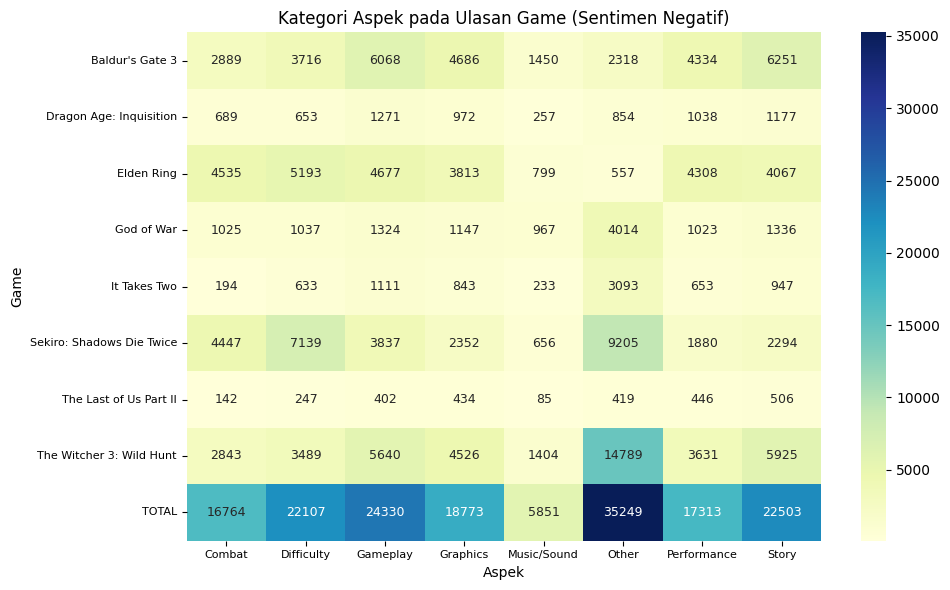

In [40]:
# Buat ulang aspect_matrix
aspect_matrix_neg = aspect_counts_negative.pivot(index='game', columns='aspects', values='count').fillna(0)

# Tambahkan baris TOTAL di bagian bawah
aspect_matrix_with_total_neg = aspect_matrix_neg.copy()
aspect_matrix_with_total_neg.loc['TOTAL'] = aspect_matrix_with_total_neg.sum()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    aspect_matrix_with_total_neg,
    annot=True,
    fmt='.0f',
    cmap='YlGnBu',
    annot_kws={"size": 9}
)

plt.title('Kategori Aspek pada Ulasan Game (Sentimen Negatif)')
plt.xlabel('Aspek')
plt.ylabel('Game')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()